<a href="https://colab.research.google.com/github/tefarov/netology_pyda5/blob/master/diploma_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение аналитических методов в ломозаготовительной отрасли

## Загрузка данных

In [0]:
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from pylab import rcParams
rcParams['figure.figsize'] = 20,9

import datetime as dt

Подгружаем данные о ломозаготовке чёрного лома на цехах. Одна строка - один ПСА (приёмо-сдаточный акт)<br/>
* **date, date_y, date_ym, date_m, date_w** - дата, год, месяц и неделя ПСА
* **sup_personat** - тип лица (физ.лицо / юр.лицо)
* **scp_weightgross, scp_weightpack, scp_loss, scp_weightloss,scp_weight** - вес брутто, вес тары (как правило автомобиля), засор, вес засора, вес чистый 
*	**scp_price, scp_cost** - цена и стоимость приобретённого лома
* **doc_transportt, doc_transport** - тип и наименование транспорта
* **doc_manager** - менеджер, осуществивший сделку
* **scp_namef** - номенклатура лома
* **dpt_namef** - наименование цеха
* **sup_type, sup_namef, sup_sender** - тип, наименование и грузоотправитель поставщика
* **scp_pricet** - тип применённой цены
* **scp_market** - рыночная цена на данный момент времени
* **scp_margintn, scp_margin** - маржа валовая (руб.) и удельная (руб./тн)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

sal_df = pd.read_csv('/content/drive/My Drive/EDU.Netology/DIP_SALES.csv',sep=';',decimal=',',encoding='cp1251')
sal_df.columns = ['date','date_y','date_ym','date_m','date_w','sup_personat','scp_weightgross','scp_weightpack','scp_loss','scp_weightloss','scp_weight','scp_price','scp_cost','doc_transportt','doc_transport','doc_manager','scp_namef','dpt_namef','sup_type','sup_namef','sup_sender','scp_pricet']
sal_df['date'] = pd.to_datetime(sal_df.date,dayfirst=True)
sal_df['date_w'] = pd.to_datetime(sal_df.date_w,dayfirst=True)
sal_df['sup_type'] = sal_df.sup_type.str.strip().str.lower()

# Филтрация выбросов и нерелевантных данных
sal_df = sal_df.loc[sal_df.scp_cost > 0]
sal_df = sal_df.loc[sal_df.sup_type != 'внутригрупповой']
sal_df = sal_df.loc[sal_df.scp_namef.str.startswith('Наименование')]                  # нам нужны только те виды ломов, которые начинаются с наименования, всё остальное - малоинтересное побочное явление
sal_df = sal_df.loc[sal_df.scp_namef.apply(lambda x: x[13:] in ['300','501','912'])]  # это основные вида лома, которые нас интересуют
sal_df = sal_df.loc[sal_df.sup_type.apply(lambda x: x in ['профессионал','физ.лицо','юр.лицо'])] # рассмотрим только релевантные группы клиентов

print("Всего записей: ",len(sal_df))

# Группируем заготовку по неделям, товарам, чтобы рассчитать понедельную рыночную цену
mkt_df = sal_df.groupby(['scp_namef','date_w'],as_index=False).sum()
mkt_df['scp_market'] = mkt_df.scp_cost / mkt_df.scp_weight

sal_cl = list(sal_df.columns)

# Исходя из рыночной цены рассчитываем прибыльность каждой сделки
sal_df = sal_df.merge(mkt_df,on=['scp_namef','date_w'],suffixes=('','_m'))  # добавляем к каждой сделке информацию о рыночной стоимости в этот день
sal_df = sal_df[sal_cl + ['scp_market']]                                      # выбираем только нужные колонки
sal_df['scp_margintn'] = sal_df.scp_market - sal_df.scp_price + 1000        # мы продадим лом на завод по рыночной цене + 1000, поэтому считаем, что нааша маржа = рыночная цена - цена закупа + 1000
sal_df['scp_margin'] = sal_df.scp_margintn * sal_df.scp_weight              # валовая маржа

sal_df.head(5)

label_headers = {'date':'Дата', 'date_y':'Год', 'date_ym':'Месяц, год', 'date_m':'Месяц', 'date_w':'Неделя', 'sup_personat':'Тип поставщика 1','sup_count':'Кол-во поставщиков','scp_weightgross':'Вес брутто, тн', 'scp_weightpack':'Вес тары, тн', 'scp_loss':'Засор, %', 'scp_weightloss':'Засор, тн', 'scp_weight':'Вес, тн', 'scp_weightav':'Ср.вес, тн','scp_price':'Цена, руб/тн', 'scp_cost':'Стоимость, руб', 'doc_transportt':'Тип транспорта', 'doc_transport':'Транспорт', 'doc_manager':'Менеджер', 'scp_namef':'Номенклатура лома', 'dpt_namef':'Цех', 'sup_type':'Тип поставщика', 'sup_namef':'Поставщик', 'sup_sender':'Грузоотправитель', 'scp_pricet':'Тип цены', 'scp_market':'Цена рыночная, руб/тн', 'scp_margintn':'Маржа, руб/тн', 'scp_margin':'Маржа валовая, руб','doc_count':'Кол-во ПСА','datemin':'Дата перв.','datemax':'Дата посл.','datelen':'Продолжительность','dateav':'Интервал между сделками','datemin':'Первая сделка','datemin_ym':'Первая сделка, месяц','datemax':'Последняя сделка','datemax_ym':'Последняя сделка, месяц','datenum':'Кол-во сделок','k_loyalty':'Коэф. лояльности'}
def fx_label(label):
  val = label_headers.get(label)
  return label if val == None else val

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Всего записей:  85875


# Анализ среднерыночной цены
Изучим динамику изменения рыночной цены понедельно

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


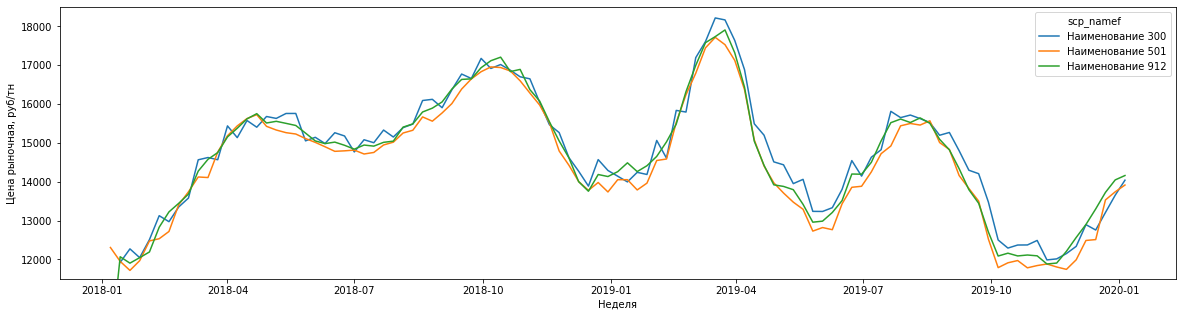

In [0]:
dsp_df = mkt_df.copy()

plt.figure(figsize=(20, 5))
# order = ['Цех 01' ,'Цех 02' ,'Цех 03' ,'Цех 04' ,'Цех 05' ,'Цех 06' ,'Цех 07' ,'Цех 08' ,'Цех 09' ,'Цех 10' ,'Цех 11' ,'Цех 12' ,'Цех 13' ,'Цех 14' ,'Цех 81']
axs = sb.lineplot(x='date_w',y='scp_market',hue='scp_namef',data=dsp_df)
axs.set_xlabel(fx_label(axs.get_xlabel()))
axs.set_ylabel(fx_label(axs.get_ylabel()))
axs.set_ylim(11500,18500)
x=1

# Анализ  поставщиков
Построим таблицу поставщиков на основании данных о заготовке, и изучим структуру поставщиков

In [0]:
sup_df = sal_df.groupby(['sup_namef','sup_personat','sup_type'],as_index=False).sum()[['sup_namef','sup_personat','sup_type','scp_weight','scp_cost','scp_margin']]
sup_df = sup_df.sort_values('scp_margin',ascending=False)

dsp_df = sal_df.groupby(['sup_namef'],as_index=False).count()[['sup_namef','date_m']]; dsp_df.columns = ['sup_namef','doc_count']
sup_df = sup_df.merge(dsp_df,on='sup_namef')
sup_df['scp_marginav'] = sup_df.scp_margin / sup_df.doc_count
sup_df['scp_margintn'] = sup_df.scp_margin / sup_df.scp_weight
sup_df['scp_weightav'] = sup_df.scp_weight / sup_df.doc_count

dat_df = sal_df[['sup_namef','date','date_ym']]#[::100]

# Находим дату и месяц первой сделки
dsp_df = dat_df.groupby('sup_namef').min()
su2_df = dsp_df.copy()
su2_df = su2_df.rename(columns={'date':'datemin','date_ym':'datemin_ym'})

# Находим дату и месяц последней сделки
dsp_df = dat_df.groupby('sup_namef').max()
su2_df = su2_df.join(dsp_df)
su2_df = su2_df.rename(columns={'date':'datemax','date_ym':'datemax_ym'})

# Поскольку в один день может быть несколько сделок, то высчитаем то количество дней в которые клиент приезжал хотя бы раз
# Это будет количество дней в которые мы совершали сделки
dsp_df = dat_df.groupby(['sup_namef','date'],as_index=False).count()
dsp_df = dsp_df.groupby('sup_namef').count()[['date']]
su2_df = su2_df.join(dsp_df)
su2_df = su2_df.rename(columns={'date':'datenum'})

# Посчитаем продолжительность наших взаимоотнощений в днях
su2_df = su2_df.assign(datelen=lambda x:(x.datemax-x.datemin).dt.days+1)
su2_df = su2_df.sort_values('datelen',ascending=False)
# Высчитаем средний период между сделками, то как часто клиент сдаёт нам лом
su2_df['dateav'] = su2_df.datelen / su2_df.datenum
su2_df['day_0'] = (su2_df.datemin - pd.to_datetime(dt.date(2018,1,1))).dt.days
su2_df['day_1'] = (pd.to_datetime(dt.date(2019,12,31))-su2_df.datemax).dt.days

# Если интервал между 2018-01-01 и первой сделки меньше, чем средний интервал между сделками у данного клиента,
# будем считать, что у него нет данных о первой сделке, т.к. скорее всего он был и раньше
su3_df = su2_df.loc[su2_df.day_0 < (su2_df.dateav *1.3)]
su3_df = su3_df[['datemin','datemin_ym']]
su3_df['datemin_ym'] = '#NoData'
su3_df['datemin'] = pd.to_datetime(dt.date(2000,1,1))
su2_df.update(su3_df)

# Если интервал между 2019-12-31 и последней сделкой меньше, чем средний интервал между сделками у данного клиента,
# будем считать, что у него нет данных о последней сделке, т.к. скорее всего он будет сдавать лом и дальше
su3_df = su2_df.loc[su2_df.day_1 < (su2_df.dateav *1.3)]
su3_df = su3_df[['datemax','datemax_ym']]
su3_df['datemax_ym'] = '#NoData'
su3_df['datemax'] = pd.to_datetime(dt.date(2000,1,1))
su2_df.update(su3_df)

# Проставим вместо субститутов нормальные np.nan, чтобы потом данные было проще фильтровать
su2_df.replace('#NoData',np.nan,inplace=True)
su2_df.replace(pd.to_datetime(dt.date(2000,1,1)),np.nan,inplace=True)

# Высчитаем коэффициент лояльности
su2_df['k_loyalty'] = (((su2_df.datelen / 365)**2 + (su2_df.datenum /104) ** 2)**0.5).fillna(0)

# Сохраним данные в таблицу с поставщиками для дальнейшего анализа
sup_df = sup_df.merge(su2_df,how='left',left_on='sup_namef',right_index=True)
sup_df = sup_df.sort_values('k_loyalty',ascending=False)

su2_df = None
su3_df = None
sup_df.head(5)

,sup_namef,sup_personat,sup_type,scp_weight,scp_cost,scp_margin,doc_count,scp_marginav,scp_margintn,scp_weightav,datemin,datemin_ym,datemax,datemax_ym,datenum,datelen,dateav,day_0,day_1,k_loyalty
0,"WOODS, ROBERT L",Физическое лицо,профессионал,24441.435259,3.602232e+08,1.800187e+07,3258,5525.435161,736.530714,7.501975,2018-04-27,2018-04,NaT,NaN,496,613,1.235887,116,1,5.056295
1,"WILLIAMS, LONE M",Физическое лицо,профессионал,9663.503836,1.442877e+08,6.623478e+06,1001,6616.861549,685.411681,9.653850,2018-04-28,2018-04,NaT,NaN,288,612,2.125000,117,1,3.237283
3729,"SCHOTT, BENEDICT E",Физическое лицо,профессионал,6.888678,8.535938e+04,2.295848e+04,253,90.744989,3332.784987,0.027228,2018-01-10,2018-01,2019-12-20,2019-12,212,710,3.349057,9,11,2.817650
36,Advance Auto Parts,Юридическое лицо,профессионал,607.577596,8.936227e+06,6.008625e+05,159,3779.009467,988.947764,3.821243,2018-01-15,2018-01,2019-12-18,2019-12,148,703,4.750000,14,13,2.394730
11,"LARA, ILDEFONSO J",Физическое лицо,профессионал,2702.183896,4.212711e+07,2.190111e+06,485,4515.693283,810.496741,5.571513,2018-02-02,2018-02,2019-11-22,2019-11,143,659,4.608392,32,39,2.269445


In [0]:
dat_df = sup_df.copy()[['sup_namef','scp_weight','scp_margintn','datelen','datenum','dateav','k_loyalty']]

# Высчитаем коэффициент лояльности
dat_df['k_loyalty'] = (( (dat_df.datelen/365)**2 + (dat_df.datenum/104)**2  )**0.5).fillna(0)

dat_df = dat_df.sort_values(['datelen','dateav'],ascending=False)
dat_df.head(20)

,sup_namef,scp_weight,scp_margintn,datelen,datenum,dateav,k_loyalty
6327,"BOLTON, LENORA V",7.779926,1873.140636,721,12,60.083333,1.978710
6702,"WARD, JOHN S",7.471593,1827.299678,721,12,60.083333,1.978710
174,Berkshire Hathaway,48.990164,2714.322922,721,21,34.333333,1.985636
365,"RAFFAE, JAMES J",26.016721,2765.900623,721,31,23.258065,1.997706
813,"NORMAN, JOHN M",25.355121,1904.125270,719,47,15.297872,2.021038
882,"RUSSELL, ANDREW P",23.387045,1990.470524,719,117,6.145299,2.268476
10526,"CHRISTENSEN, ALTHEA",2.921509,2017.245376,718,16,44.875000,1.973130
543,"KEARNS, PATRICK J",24.589329,2361.414633,717,82,8.743902,2.116713
10422,"FAGIANO, CARISSA",2.357398,2569.641669,716,3,238.666667,1.961856
9576,"SMITH, SHAQUNIA R",4.080509,1819.980876,716,5,143.200000,1.962233


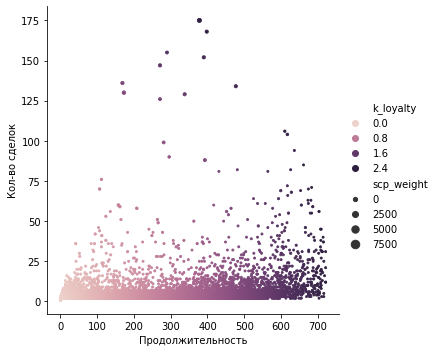

In [0]:
dsp = ('datelen','datenum','k_loyalty','scp_weight','scp_margintn')

dsp_df = dat_df
dsp_df = dsp_df.loc[dsp_df.k_loyalty<2]

axs = sb.relplot(x=dsp[0],y=dsp[1],hue=dsp[2],size=dsp[3],data=dsp_df,marker='.',edgecolor=None)
if dsp[0]=='k_loyalty': plt.xlim(0,2)
if dsp[1]=='k_loyalty': plt.ylim(0,2)
plt.xlabel(fx_label(dsp[0]))
plt.ylabel(fx_label(dsp[1]))
plt.show()

## Анализ маржи (доходности)
Проведём анализ доходности (маржинальности) деятельности. Маржа - разница между тем почём лом продадут и тем почём его купили. Изучим распределение маржи по поставщикам. Изучим то насколько доходна для нас каждая из групп поставщиков.

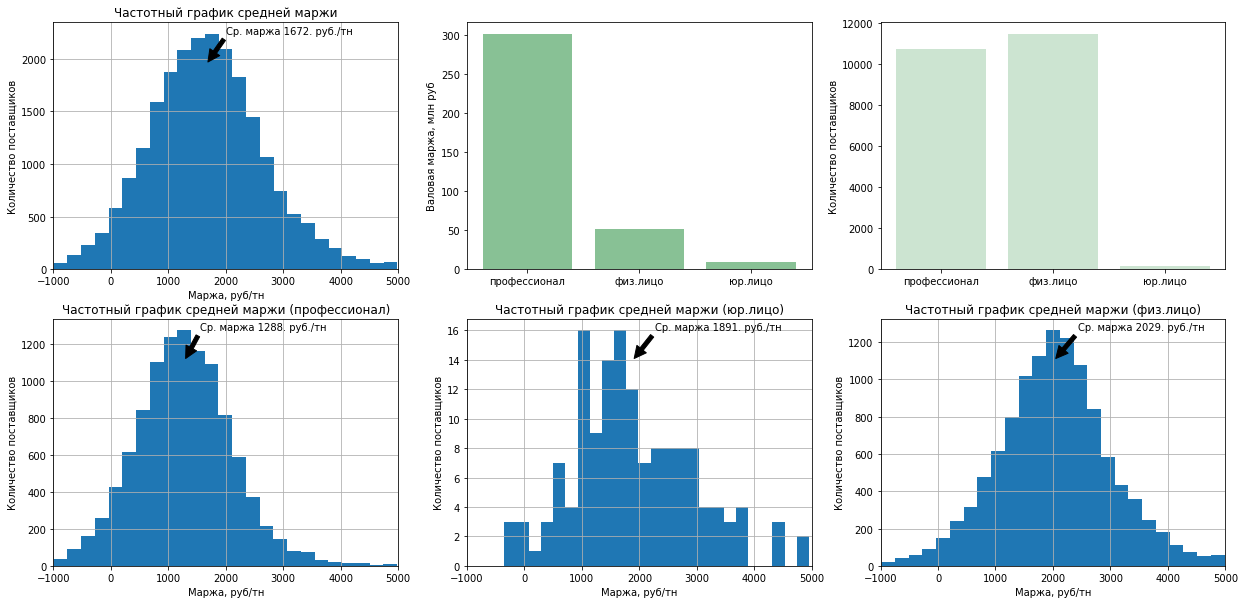

In [0]:
dat_df = sup_df.copy()
# фильтруем выбросы по маржинальности
dat_df = dat_df.loc[(dat_df.scp_margintn >= -1000) & (dat_df.scp_margintn <=5000)]

plt.figure(figsize=(21, 10))
G = gs.GridSpec(2,3)

axs = plt.subplot(G[0,0])

avg = dat_df.scp_margintn.mean()
ann = f"{avg:#0}"
n, bins, patches = axs.hist(dat_df['scp_margintn'], 25)
axs.set_title(f'Частотный график средней маржи')
axs.set_xlabel(fx_label('scp_margintn'))
axs.set_ylabel('Количество поставщиков')
axs.set_xlim(-1000,5000)
axs.grid(True)

t = axs.get_ybound()[1]

axs.annotate(f"Ср. маржа {avg:#.0f} руб./тн",(avg,t/1.2),xytext=(avg*1.2,t/1.05),arrowprops={'facecolor':'black', 'shrink':0.05})
dsp = [];lbl=[]

i = 0 
for sup in dat_df.sup_type.unique():
  dsp_df = dat_df.loc[dat_df.sup_type== sup]
  lbl.append(sup)
  dsp.append(dsp_df.scp_margin)


  avg = dsp_df.scp_margintn.mean()
  ann = f"{avg:#0}"

  axs = plt.subplot(G[1,i]);i+=1

  n, bins, patches = axs.hist(dsp_df['scp_margintn'], 25)
  axs.set_title(f'Частотный график средней маржи ({sup})')
  axs.set_xlabel(fx_label('scp_margintn'))
  axs.set_ylabel('Количество поставщиков')
  axs.set_xlim(-1000,5000)
  axs.grid(True)

  t = axs.get_ybound()[1]

  axs.annotate(f"Ср. маржа {avg:#.0f} руб./тн",(avg,t/1.2),xytext=(avg*1.2,t/1.05),arrowprops={'facecolor':'black', 'shrink':0.05})


dsp_df = dat_df.copy().sort_values('scp_margin',ascending=False)
dsp_df = dsp_df[200:]

# axs.boxplot(dsp,vert=False,labels=lbl,showmeans=True)
# axs.set_title(f'Распределение валовой маржи по группам клиентов')
# axs.set_xlim(-0.5*10**5,5*10**5)

dsp_df = dat_df.groupby('sup_type',as_index=False).sum()#[['sup_type','scp_margin']]

axs = plt.subplot(G[0,1])
axs.bar(dsp_df.sup_type,dsp_df.scp_margin/(10**6),color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel('Валовая маржа, млн руб')

dsp_df = dat_df.groupby('sup_type',as_index=False).count()#[['sup_type','scp_margin']]

axs = plt.subplot(G[0,2])
axs.bar(dsp_df.sup_type,dsp_df.scp_margin,color=(86/255,168/256,105/255,0.3))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel('Количество поставщиков')

plt.show()

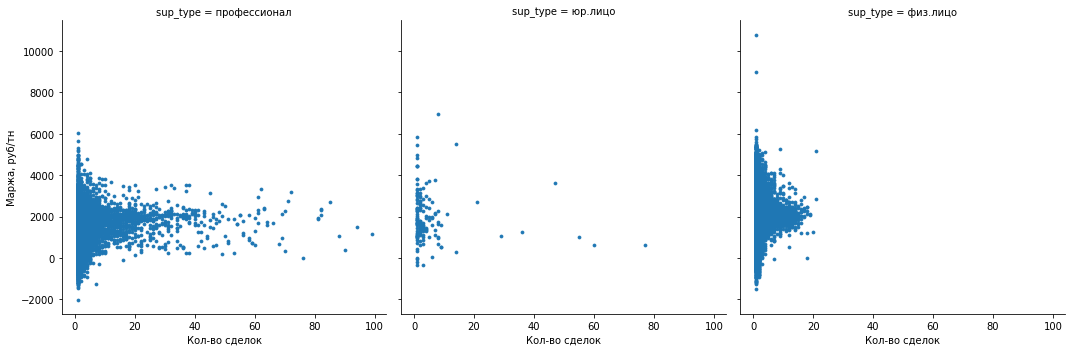

In [0]:
dat_df = sup_df.copy()
dat_df = dat_df.loc[dat_df.sup_type.apply(lambda x: x in ['профессионал','физ.лицо','юр.лицо'])] 
# dat_df = dat_df.loc[dat_df.scp_weight<1000]
dat_df = dat_df.loc[dat_df.datenum<100]
# dat_df = dat_df.loc[(dat_df.scp_margintn<2000) & (dat_df.scp_margintn>-1000)]
dsp_df = dat_df

# 0:x   1:y   2:hue   3:cols
dsp = ('datenum','scp_margintn',None,'sup_type')

axs = sb.relplot(x=dsp[0],y=dsp[1],hue=dsp[2],col=dsp[3],data=dsp_df,marker='.',edgecolor=None)
# plt.xlim((-2000,8000))
# plt.ylim((0,100))
axs.set(xlabel=fx_label(dsp[0]),ylabel=fx_label(dsp[1]))

plt.show()
x=1

## Анализ лояльности

Изучим периоды в которые приходили у ходили наши клиенты, посмотрим когда сформировалась наша клиентская база

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3723: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


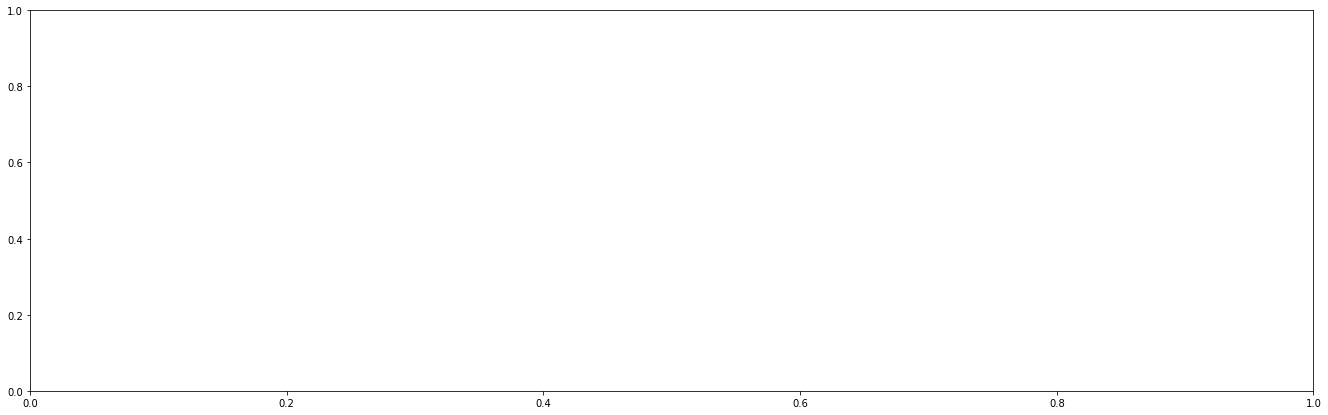

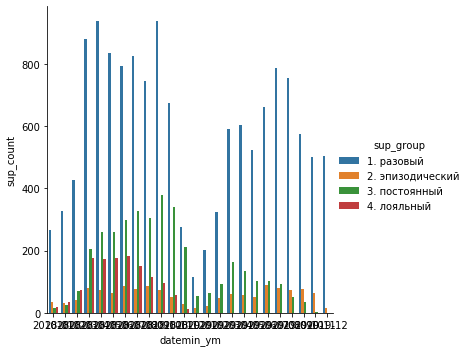

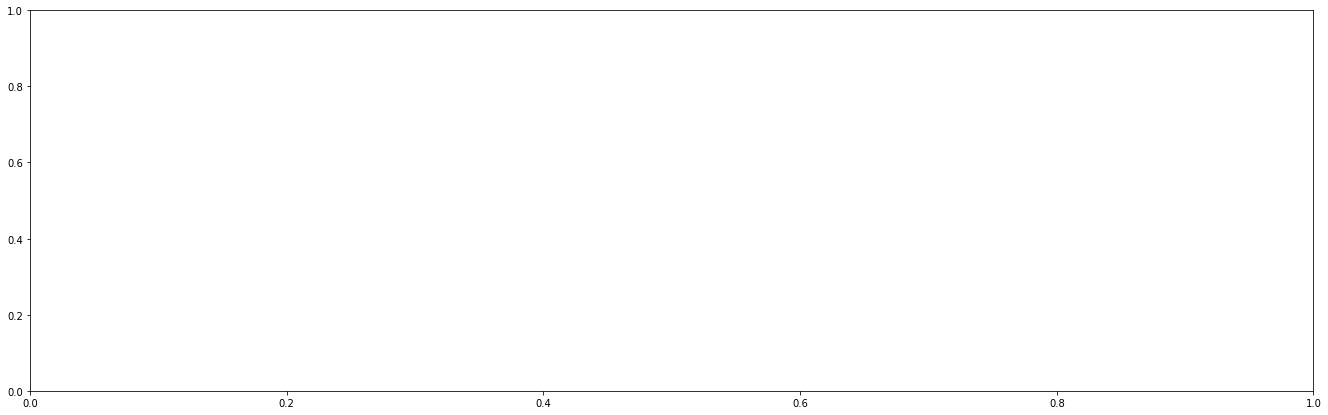

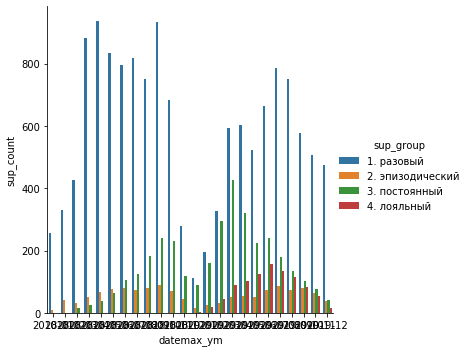

In [0]:
def fx_supgroup(periodlen):
  if periodlen == None:
    return None
  elif periodlen<=10: return  '1. разовый'
  elif periodlen<=50: return  '2. эпизодический'
  # elif periodlen<=150: return '3. полугодовой'
  elif periodlen<=365: return '3. постоянный'
  else: return '4. лояльный'

dat_df = sup_df.copy()
dat_df = dat_df.loc[dat_df.sup_type.apply(lambda x: x in ['профессионал','физ.лицо','юр.лицо'])] 
dat_df['sup_group'] = dat_df.datelen.apply(lambda x: fx_supgroup(x))

plt.figure(figsize=(23, 7))
axs = plt.subplot()
dsp_df = dat_df.loc[dat_df.datemin_ym.notna()]
dsp_df = dsp_df.groupby(['datemin_ym','sup_group'],as_index=False).count()[['datemin_ym','sup_namef','sup_group']]
dsp_df = dsp_df.rename(columns={'sup_namef':'sup_count'})
sb.catplot(x="datemin_ym", y="sup_count",hue='sup_group',kind='bar',data=dsp_df,ax=axs)
axs.set_xlabel(fx_label(axs.get_xlabel()))
axs.set_ylabel(fx_label(axs.get_ylabel()))

plt.figure(figsize=(23, 7))
axs = plt.subplot()
dsp_df = dat_df.loc[dat_df.datemax_ym.notna()]
dsp_df = dsp_df.groupby(['datemax_ym','sup_group'],as_index=False).count()[['datemax_ym','sup_namef','sup_group']]
dsp_df = dsp_df.rename(columns={'sup_namef':'sup_count'})
sb.catplot(x="datemax_ym", y="sup_count",hue='sup_group',kind='bar',data=dsp_df,ax=axs)
axs.set_xlabel(fx_label(axs.get_xlabel()))
axs.set_ylabel(fx_label(axs.get_ylabel()))

x=None

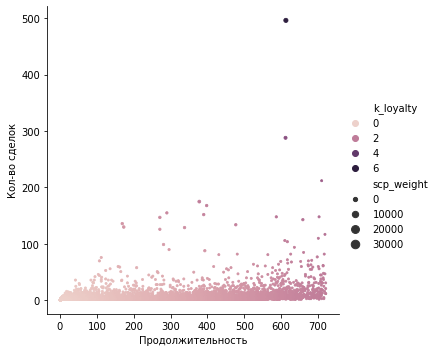

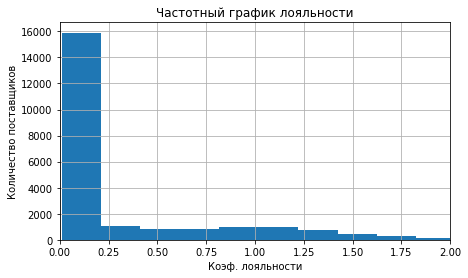

In [0]:
dat_df = sup_df.copy()
# dat_df = dat_df.loc[dat_df.scp_weight<1000]
# dat_df = dat_df.loc[dat_df.k_loyalty<1]

dsp = ('datelen','datenum','k_loyalty','scp_weight','scp_margintn')

axs = sb.relplot(x=dsp[0],y=dsp[1],hue=dsp[2],size=dsp[3],data=dat_df,marker='.',edgecolor=None)
if dsp[0]=='k_loyalty': plt.xlim(0,2)
if dsp[1]=='k_loyalty': plt.ylim(0,2)
plt.xlabel(fx_label(dsp[0]))
plt.ylabel(fx_label(dsp[1]))
plt.show()

dsp = ('k_loyalty',None)

plt.figure(figsize=(7, 4))
axs = plt.subplot()
n, bins, patches = axs.hist(dat_df[dsp[0]], 25)
axs.set_title(f'Частотный график лояльности')
axs.set_xlabel(fx_label(dsp[0]))
axs.set_ylabel('Количество поставщиков')
axs.set_xlim(0,2)
axs.grid(True)

### Вывод
Изучая среднюю маржинальность закупа можно отметить, что она соответствует нормальному распределению как в целом по компании, так и по отдельным группам, что в целом говорит о естественном характере её распределения.
Наиболее доходная для нас группа - профессионалы, хотя средняя маржинальность у них ниже, но в абсолютном плане они приносят наибольший доход, при соизмеримой численности. Группы физических и юридических лиц - эффективнее в удельном плане, но в абсоюлютном - несоизмеримы с профессионалами.
Важно также отметить, что есть большие группы клиентов, с низким числом сделок, но при этом с низкой маржой. Данному факту стоит уделить дополнительное внимание, т.к. это может иметь как естественные причины (поставка премиальных сортов лома, различные официальные лица одного клиента) так и причины с корыстным умыслом.


## Факторы влияния
Проведём анализ факторов, влияющих на маржинальность лома с применением матрицы корреляций. Факторов не очень много : общий вес лома, сданного клиентом, средний вес одной партии сданного лома, удельная маржинальность. Остальные факторы (количество сделок) естественным образом взаимосвязаны, и потому будут показывать высокий уровень корреляции.

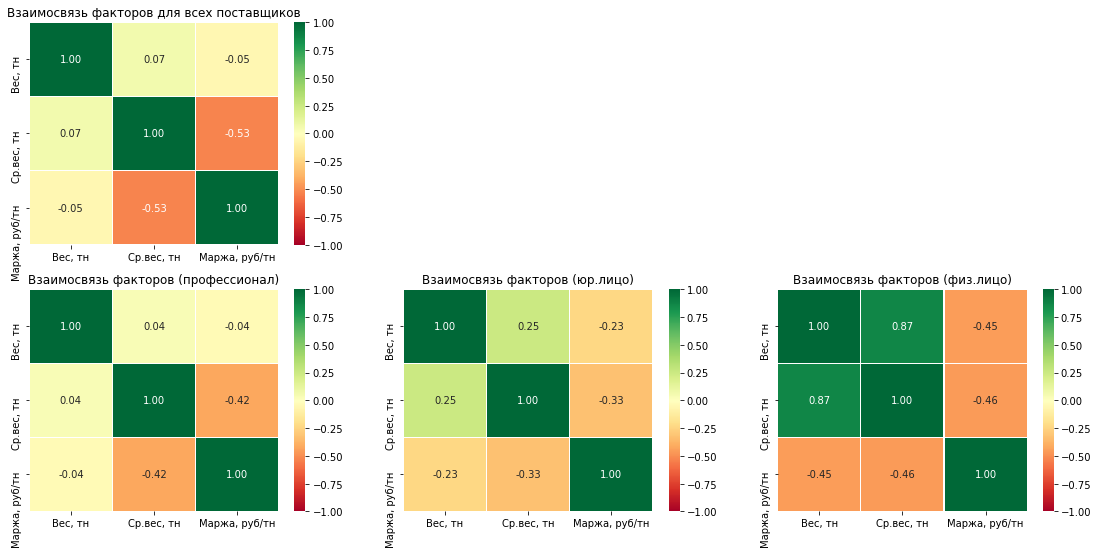

In [0]:
factors = ['sup_type','scp_weight','scp_weightav','scp_margintn']
labels = list(map(fx_label,factors[1:]))

dat_df = sup_df.copy()
dat_df = dat_df.loc[dat_df.sup_type.apply(lambda x: x in ['профессионал','физ.лицо','юр.лицо'])] 
dat_df = dat_df[factors]
# labels = ['вес общий','вес ср.','маржа, р/тн']

plt.figure(figsize=(19,9))
G = gs.GridSpec(2,3)

axs = plt.subplot(G[0,0])
sb.heatmap(dat_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,vmin=-1,vmax=1,fmt=f"#.2f",ax=axs)
axs.set_title(f'Взаимосвязь факторов для всех поставщиков')
axs.set_xticklabels(labels)
axs.set_yticklabels(labels)

i = 0 
for sup in dat_df.sup_type.unique():
  dsp_df = dat_df.loc[dat_df.sup_type== sup]

  axs = plt.subplot(G[1,i]);i+=1

  sb.heatmap(dsp_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,vmin=-1,vmax=1,fmt=f"#.2f",ax=axs)
  axs.set_title(f'Взаимосвязь факторов ({sup})')
  axs.set_xticklabels(labels)
  axs.set_yticklabels(labels)
  # plt.title(f'Взаимосвязь факторов ')

plt.show()

### Вывод
Как и было показано ранее, имеется обратная взаимосвязь факторов средней маржи и среднего веса сданной продукции. Важно отметить, что такая взаимосвязь присутствует как в целом по компании, так и в отдельных группах. Такая взаимосвязь логична для групп профессионалов и юридических лиц, но не должна быть свойственна для физических лиц, поскольку эта группа должна характеризоваться низкой лояльностью и низкой эластичностью спроса. Данный факт требует дополнительного анализа и может характеризоваться как низким качеством сегментации клиентской базы так и хищениями.

# Анализ менеджеров
Изучим показатели менеджеров по закупке лома

In [0]:
mng_df = sal_df.groupby(['doc_manager'],as_index=False).sum()[['doc_manager','scp_weight','scp_cost','scp_margin']]
mng_df = mng_df.sort_values('scp_margin',ascending=False)

dsp_df = sal_df.groupby(['doc_manager'],as_index=False).count()[['doc_manager','date_m']]; dsp_df.columns = ['doc_manager','doc_count']
mng_df = mng_df.merge(dsp_df,on='doc_manager')
mng_df['scp_marginav'] = mng_df.scp_margin / mng_df.doc_count
mng_df['scp_margintn'] = mng_df.scp_margin / mng_df.scp_weight
mng_df['scp_weightav'] = mng_df.scp_weight / mng_df.doc_count

mng_df.head(5)

,doc_manager,scp_weight,scp_cost,scp_margin,doc_count,scp_marginav,scp_margintn,scp_weightav
0,<НЕТ>,26460.695893,3.654046e+08,5.355378e+07,39650,1350.662846,2023.899223,0.667357
1,Менеджер 34,58872.824527,8.727305e+08,4.147417e+07,6957,5961.501816,704.470500,8.462387
2,Менеджер 28,45875.429384,6.722548e+08,3.774604e+07,4952,7622.383645,822.794344,9.264020
3,Менеджер 19,28111.304498,4.105195e+08,3.220767e+07,6317,5098.569755,1145.719337,4.450104
4,Менеджер 25,27422.151237,4.010072e+08,2.793496e+07,3874,7210.884064,1018.700707,7.078511


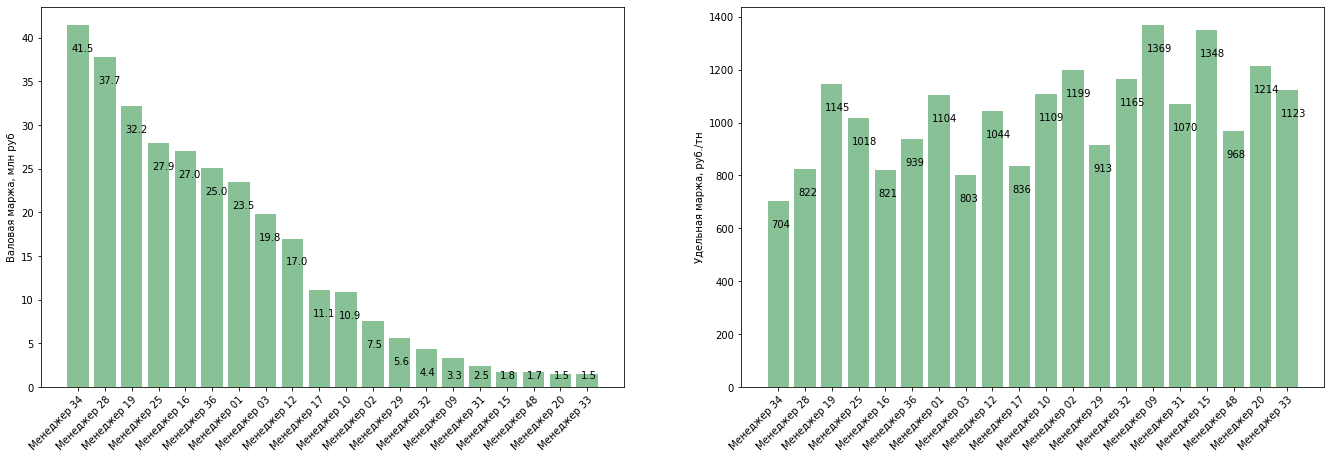

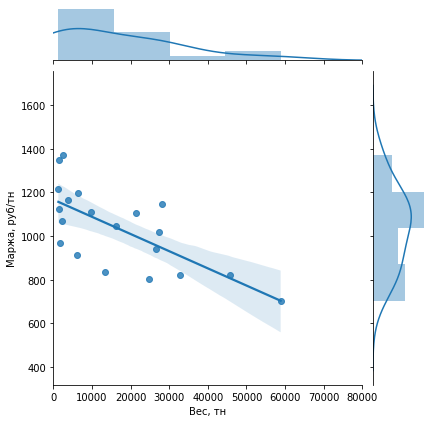

In [0]:
dsp_df = mng_df.copy()
dsp_df = dsp_df.loc[dsp_df.doc_manager != '<НЕТ>']
dsp_df = dsp_df.groupby('doc_manager',as_index=False).sum()
dsp_df = dsp_df.sort_values('scp_margin',ascending=False)
dsp_df = dsp_df.head(20)

plt.figure(figsize=(23, 7))
G = gs.GridSpec(1,2)

axs = plt.subplot(G[0,0])
# axs = plt.subplot()

# axs = plt.subplot(G[0,1])
axs.bar(dsp_df.doc_manager,dsp_df.scp_margin/(10**6),color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel('Валовая маржа, млн руб')

x=len(dsp_df); y=0
for rec in reversed(list(dsp_df.itertuples())):
  x-= 1
  y = max(1,rec.scp_margin/10**6 - 3);
  axs.annotate(f'{rec.scp_margin/10**6:#,.1f}',(x-0.25,y))
  # axs.annotate(f'{rec.scp_margin/10**6:#,.1f} ({rec.doc_manager})',(x,y0),xytext=(x,y+3),arrowprops={'edgecolor':'#509050','arrowstyle':'->'})
  # Rotate the tick labels and set their alignment.
  plt.setp(axs.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

axs = plt.subplot(G[0,1])

axs.bar(dsp_df.doc_manager,dsp_df.scp_margintn,color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel('Удельная маржа, руб./тн')

x=len(dsp_df); y=0
for rec in reversed(list(dsp_df.itertuples())):
  x-= 1
  y = max(2,rec.scp_margintn-100);
  axs.annotate(f'{int(rec.scp_margintn):#0}',(x-0.25,y))
  plt.setp(axs.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()
# axs = plt.subplot(G[1,2])

axs = sb.jointplot(y='scp_margintn',x='scp_weight',data=dsp_df,kind='reg')
plt.xlim((0,80000))
plt.ylabel(fx_label('scp_margintn'))
plt.xlabel(fx_label('scp_weight'))
plt.show()

# Кластеризация поставщиков

<Figure size 1656x504 with 0 Axes>

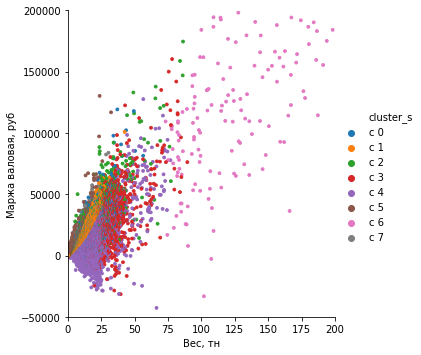

In [0]:
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans, MeanShift, Birch, DBSCAN
from sklearn.preprocessing import MinMaxScaler as scaler

lim = 200

dat_df = sup_df.copy()
dat_df = dat_df.loc[dat_df.scp_weight < lim]
dat_df = dat_df.sort_values('scp_weight',ascending=False)
# dat_df = dat_df.head(1000)

scl = scaler()

dsp_df = dat_df[['scp_margintn','scp_weight','k_loyalty']]
dsp_df = pd.DataFrame(scl.fit_transform(dsp_df),index=dsp_df.index)

# bnd = estimate_bandwidth(dsp_df, quantile=0.12, n_samples=500)
# clust = MeanShift(bnd,cluster_all=True)
clust = KMeans(random_state=5)
# clust = Birch(threshold=0.005,n_clusters=8)
# clust = DBSCAN(0.03,min_samples=5)

dsp_df['cluster'] = clust.fit_predict(dsp_df)
dat_df['cluster'] = dsp_df.cluster
dat_df['cluster_s'] = dat_df.cluster.map(lambda x: f"c {int(x)}")
# dat_df = dat_df.sort_values('cluster_s')

ord_ls = list(pd.Series(dat_df.cluster_s.unique()).sort_values())

dsp = ('scp_weight','scp_margin')

plt.figure(figsize=(23, 7))
# axs = plt.subplot()

axs = sb.relplot(x=dsp[0],y=dsp[1],hue='cluster_s',hue_order=ord_ls,data=dat_df,marker='.',edgecolor=None)
# plt.ylim((0,lim))
# plt.xlim((-1000,6000))
if dsp[0]=='k_loyalty':axs.set(xlim=(0,2))
if dsp[1]=='k_loyalty':axs.set(ylim=(0,2))
if dsp[0]=='scp_margin':axs.set(xlim=(-50000,2*10**5))
if dsp[1]=='scp_margin':axs.set(ylim=(-50000,2*10**5))
if dsp[0]=='scp_weight':axs.set(xlim=(0,lim))
if dsp[1]=='scp_weight':axs.set(ylim=(0,lim))
axs.set(xlabel=fx_label(dsp[0]),ylabel=fx_label(dsp[1]))
plt.show()

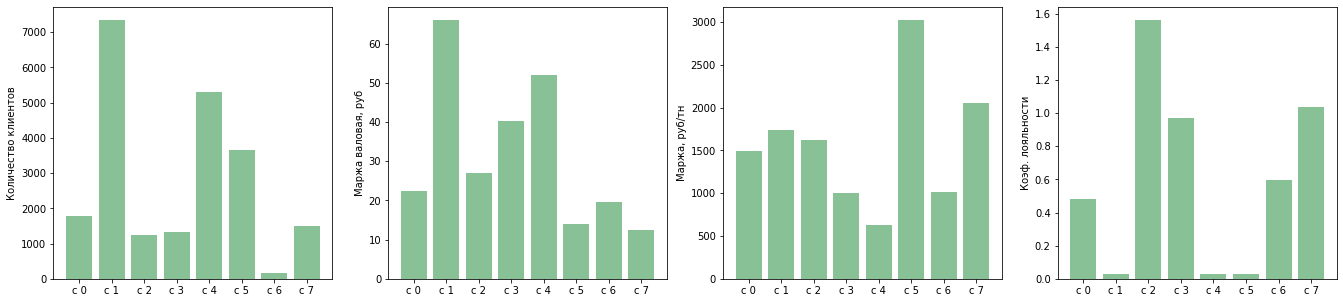

l:8,  c:4,  r:3


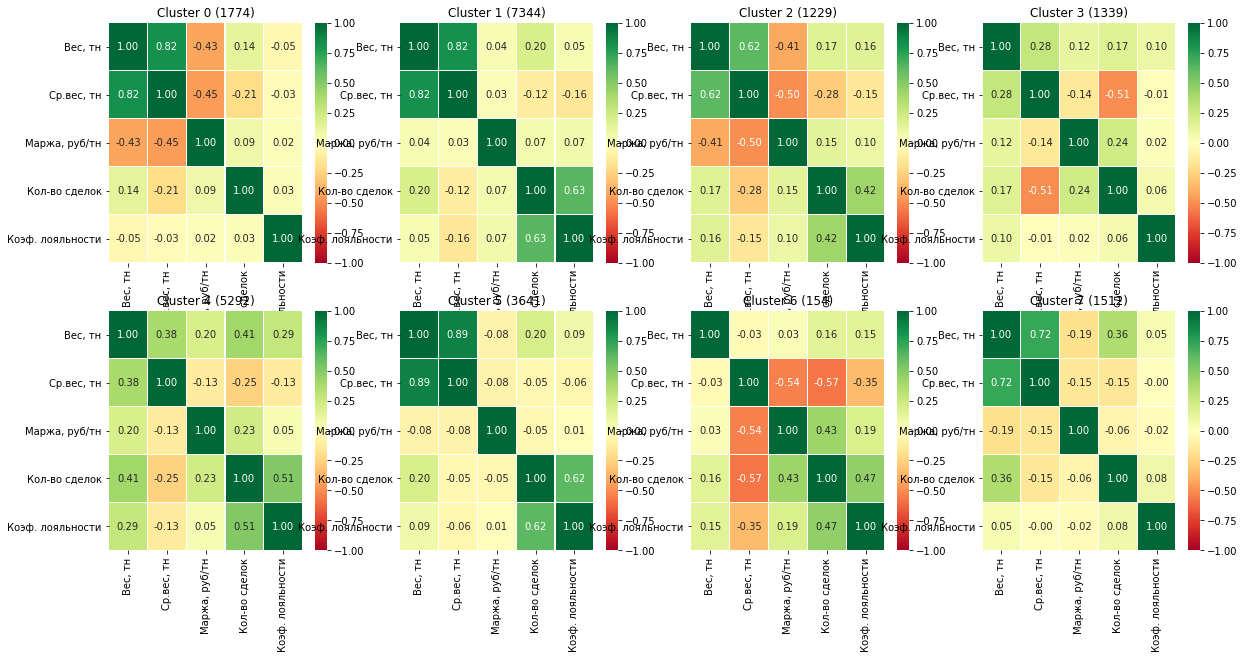

In [0]:
plt.figure(figsize=(23,5))
G = gs.GridSpec(1,4)

axs = plt.subplot(G[0,0])
dsp_df = dat_df.groupby(['cluster_s'],as_index=False).count()
axs.bar(dsp_df.cluster_s,dsp_df.scp_margin,color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel('Количество клиентов')

axs = plt.subplot(G[0,1])
dsp_df = dat_df.groupby(['cluster_s'],as_index=False).sum()
axs.bar(dsp_df.cluster_s,dsp_df.scp_margin/(10**6),color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel(fx_label('scp_margin'))

axs = plt.subplot(G[0,2])
# dsp_df = dat_df.groupby(['cluster_s'],as_index=False).sum()
dsp_df['scp_margintn'] = dsp_df.scp_margin / dsp_df.scp_weight
axs.bar(dsp_df.cluster_s,dsp_df.scp_margintn,color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel(fx_label('scp_margintn'))

axs = plt.subplot(G[0,3])
dsp_df = dat_df.groupby(['cluster_s'],as_index=False).mean()
# dsp_df['scp_margintn'] = dsp_df.scp_margin / dsp_df.scp_weight
axs.bar(dsp_df.cluster_s,dsp_df.k_loyalty,color=(86/255,168/256,105/255,0.7))
axs.ticklabel_format(axis='y',style='plain')
axs.set_ylabel(fx_label('k_loyalty'))

# axs.bar(dsp_df.cluster_s,dsp_df.scp_margin/(10**6),color=(86/255,168/256,105/255,0.7))
# axs.set_ylabel('Валовая маржа, млн руб')
plt.show()

cls_sr = pd.Series(dat_df.cluster.unique()).sort_values().head(10)
l = len(cls_sr)
w = 5
c = 4
r = int(l/c)+1
print(f"l:{l},  c:{c},  r:{r}")


plt.figure(figsize=(c*w, r*w))
G = gs.GridSpec(r,c)

ci = 0; ri = 0
for val in cls_sr:
  dsp_df = dat_df.loc[dat_df.cluster == val][['scp_weight','scp_weightav','scp_margintn','datenum','k_loyalty']]
  labels = list(map(fx_label,dsp_df.columns))

  if ci>=c:
    ci = 0; ri+= 1
  
  if len(dsp_df) > 9:
    axs = plt.subplot(G[ri,ci])
    sb.heatmap(dsp_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,vmin=-1,vmax=1,fmt=f"#.2f",ax=axs)
    axs.set_title(f"Cluster {int(val)} ({len(dsp_df)})")
    axs.set_xticklabels(labels)
    axs.set_yticklabels(labels)
    ci+= 1 